# Looped equation

*NOTE: This file solves the looped equations directly, as opposed to their phi derivatives
in `dphi looped eq (...).ipynb` and `dphi looped integrated.ipynb`

The looped equation `MHD_parsed.eval_loop(n=n_eval)` solves for everything at $n=n_{eval}-1$ (and $B_\psi$ at $n=n_{eval}-3$)

This file uses coefficients from `Validating coefs.ipynb` and `Validating coefs Yn.ipynb`

In [1]:
# This file implements and tests recursion relations
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

# for importing MHD_parsed codes
import sys
sys.path.insert(1,'../python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *


debug_path = '../test_data_eduardo/'

import MHD_parsed
from equilibrium import *

from looped_solver import *

Detected 16 CPU's. Setting n_jobs to #CPU/2.


Axis shape:


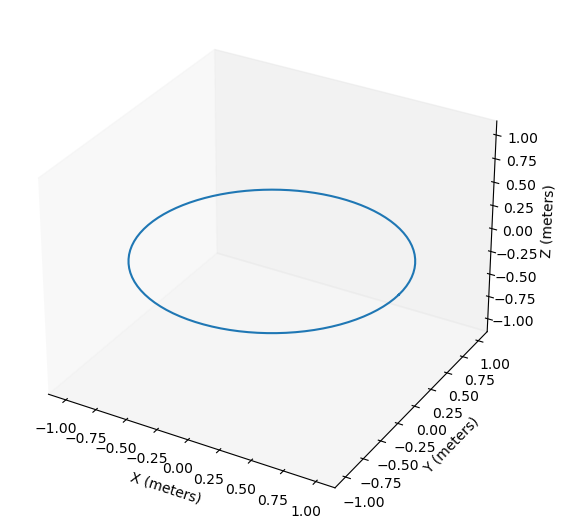

solve_integration_factor: average p_eff: 0.52564852
solve_integration_factor: average f_eff: 0.05528828529644362
integral_mode is spline


In [2]:
# No B theta
# The only case with non-trivial an-isotropic pressure
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'circ/', 
        R_array=[2,0,1,2,0.0001,0],
        Z_array=[1,2,0,0.001]
    )
n_eval = 3
Delta_offset_measured = np.average(Delta_coef_cp[n_eval-1].get_constant().content)

# It's called this for replacing with self. during integration into Equilibrium
equilibrium_self = Equilibrium.from_known(
    X_coef_cp=X_coef_cp.mask(2),
    Y_coef_cp=Y_coef_cp.mask(2),
    Z_coef_cp=Z_coef_cp.mask(2),
    B_psi_coef_cp=B_psi_coef_cp.mask(0),
    B_theta_coef_cp=B_theta_coef_cp.mask(2),
    B_denom_coef_c=B_denom_coef_c.mask(2),
    B_alpha_coef=B_alpha_coef.mask(1),
    iota_coef=iota_coef.mask(0), 
    kap_p=kap_p, 
    dl_p=dl_p, 
    tau_p=tau_p,
    eta=eta,
    p_perp_coef_cp = p_perp_coef_cp.mask(2), 
    Delta_coef_cp = Delta_coef_cp.mask(2))

# Usage and masking example of the looped equation (should yield 0)

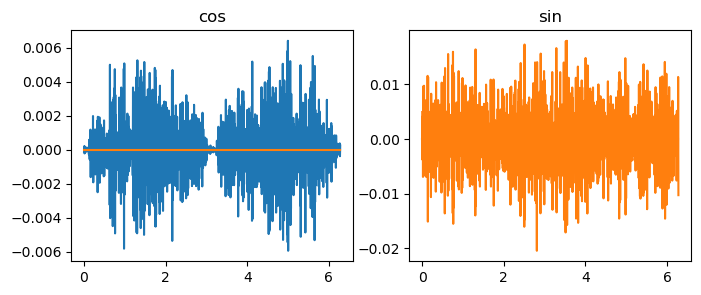

In [3]:
looped_original = MHD_parsed.eval_loop(n_eval, \
    X_coef_cp, Y_coef_cp, Z_coef_cp.mask(n_eval-1).zero_append(), \
    B_theta_coef_cp.mask(n_eval-1).zero_append(), \
    B_psi_coef_cp.mask(n_eval-3).zero_append(),\
    B_alpha_coef, B_denom_coef_c.mask(n_eval-1).zero_append(), \
    p_perp_coef_cp.mask(n_eval-1).zero_append(), \
    Delta_coef_cp.mask(n_eval-1).zero_append(), kap_p, dl_p, tau_p, iota_coef).cap_m(n_eval)
looped_original.display_content()

In [4]:

# At even order, calculate B_psi[n-2,0], Y[n,0] and the average of Delta[n,0]
# (called 'Delta_offset' below)
# target_len_phi: target phi length of the solution
def solve(n_unknown, target_len_phi,
    filtered_inv_looped_fft_operator, filtered_RHS_0_offset, coef_Delta):
    out_dict_solve = {}
    # Solution with zero Delta_offset (or at odd orders, the exact soution)
    
    filtered_solution_0_offset = np.tensordot(filtered_inv_looped_fft_operator, filtered_RHS_0_offset, 2)
    if n_unknown%2==0:
        # To have periodic B_psi, the constant component of dphi B_psi
        # must be 0. This means filtered_solution[-2,0] should be zero.
        # (-2: B_psi is always the second last row in the solution.)
        # Note that since coef_Delta is a constant, the contribution of Delta_offset
        # to the RHS is phi-independent.
        # Because the looped ODE is now treated as a linear equation,
        # the Delta_offset dependence of filtered_solution[-2,0] is linear.
        # How much a Delta_offset of 1 shift -filtered_solution[-2,0]
        fft_Delta_offset_1_contribution = np.fft.fft(coef_Delta.content*np.ones((1, filtered_RHS_0_offset.shape[1])),axis=1)
        B_psi_Delta_offset_1_contribution = np.tensordot(filtered_inv_looped_fft_operator, fft_Delta_offset_1_contribution)
        # The amount of Delta_offset required
        Delta_offset = -filtered_solution_0_offset[-2,0]/B_psi_Delta_offset_1_contribution[0,0]
        out_dict_solve['Delta_offset'] = Delta_offset
        # Readjust the RHS with Delta_offset now known.
        # For RHS with more than 2 components, Delta_offset only contributes to
        # the center two elements, because coef_Delta has only 2 chi components.
        # Padding the Delta_offset contribution to the same size as the RHS.
        Delta_offset_contrib = np.zeros_like(filtered_RHS_0_offset)
        len_chi = Delta_offset_contrib.shape[0]
        # Set the center two rows
        Delta_offset_contrib[len_chi//2-1: len_chi//2+1] =\
            np.ones((1,Delta_offset_contrib.shape[1]))*coef_Delta.content*Delta_offset
        # FFT
        Delta_offset_contrib = np.fft.fft(Delta_offset_contrib,axis=1)
        # Adding Delta_offset contributions to the solution
        filtered_solution = filtered_solution_0_offset+np.tensordot(filtered_inv_looped_fft_operator, Delta_offset_contrib, 2)
        out_dict_solve['filtered_solution_0_offset'] = filtered_solution_0_offset
    else:
        filtered_solution = filtered_solution_0_offset
    # Padding solution to a desired len_phi
    padded_solution = fft_pad(
        filtered_solution,
        target_len_phi,
        axis=1
    )
    ifft_solution = np.fft.ifft(padded_solution, axis=1)
    out_dict_solve['solution'] = ifft_solution
    out_dict_solve['padded_solution'] = padded_solution
    out_dict_solve['filtered_solution'] = filtered_solution
    out_dict_solve['filtered_inv_looped_fft_operator'] = filtered_inv_looped_fft_operator
    return(out_dict_solve)



# Solving the looped equation
Testing the integrated version of the code in `Direct looped (...).ipynb`

In [7]:
solution2 = iterate_looped(
    n_unknown=2, max_freq=500, target_len_phi=1000,
    X_coef_cp=X_coef_cp, 
    Y_coef_cp=Y_coef_cp, 
    Z_coef_cp=Z_coef_cp,
    p_perp_coef_cp=p_perp_coef_cp, 
    Delta_coef_cp=Delta_coef_cp,
    B_psi_coef_cp=B_psi_coef_cp, 
    B_theta_coef_cp=B_theta_coef_cp,
    B_alpha_coef=B_alpha_coef,
    B_denom_coef_c=B_denom_coef_c,
    kap_p=kap_p, 
    tau_p=tau_p, 
    dl_p=dl_p,
    eta=eta, 
    iota_coef=iota_coef,
    lambda_coef_Delta_offset = equilibrium_self.looped_coef_lambdas['lambda_coef_delta']
)

solve_integration_factor: average p_eff: 0.7008646933333332
solve_integration_factor: average f_eff: 0.023694043878417632
integral_mode is spline
filtered_inv_looped_fft_operator (2, 1000, 2, 1000)


dict_keys(['B_theta_n', 'Delta_offset', 'B_psi_nm2', 'vec_free', 'O_einv', 'vector_free_coef'])
Delta_offset code.     (0.8938404940300384+8.766970922558072e-16j)
Delta_offset should be (-0.8938412009000001+0j)
B_psi00
Difference


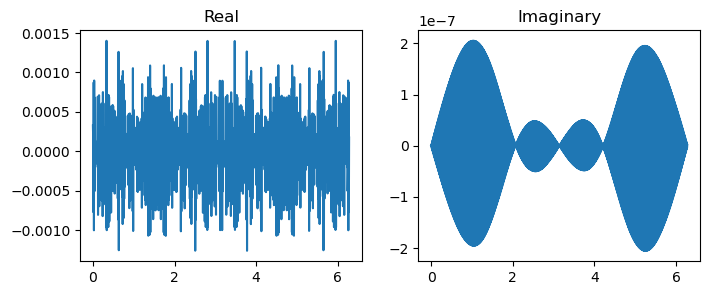

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            5.229e-03       4.191e-04      
Worst:          4.581e-01       1.402e-03      
Std             2.145e-02       3.006e-04      
Total imaginary component
0.0

Difference


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  A_content_padded[a_pad_row:shape[0]-a_pad_row,a_pad_col:shape[1]-a_pad_col] = A.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:135: ComplexWarning: Casting complex values to real discards the imaginary part
  B_content_padded[b_pad_row:shape[0]-b_pad_row,b_pad_col:shape[1]-b_pad_col] = B.content


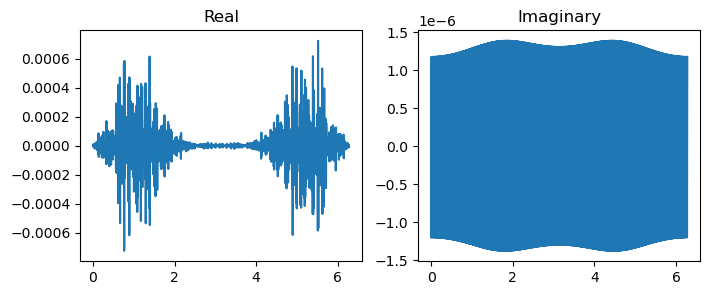

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            5.571e-04       8.623e-05      
Worst:          8.065e-02       7.230e-04      
Std             2.764e-03       1.213e-04      
Total imaginary component
0.0

Difference


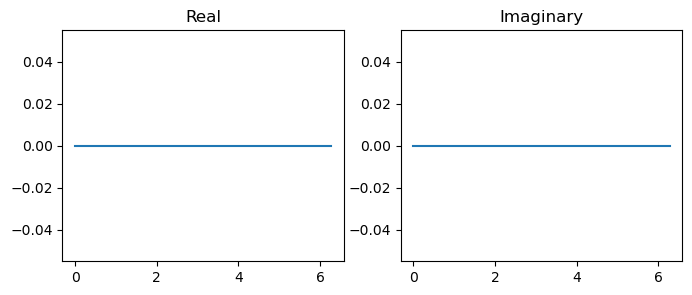

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            0.e+00          0.e+00         
Worst:          0.e+00          0.e+00         
Std             0.e+00          0.e+00         
Total imaginary component
0.0



In [8]:
print(solution2.keys())
print('Delta_offset code.    ',solution2['Delta_offset'])
print('Delta_offset should be', Delta_offset_measured)
print('B_psi00')
B_psi0_code = solution2['B_psi_nm2']
compare_chiphifunc(B_psi0_code.dphi(), B_psi_coef_cp[0].dphi(),
                   fourier_mode=False)

Y20_code = ChiPhiFunc(np.array([solution2['vec_free']]))
compare_chiphifunc(Y20_code, Y_coef_cp[2].get_constant(), 
                   fourier_mode=False)

B_theta_20_code = solution2['B_theta_n']
compare_chiphifunc(B_theta_20_code, B_theta_coef_cp[2], 
                   fourier_mode=False)

In [9]:
solution3 = iterate_looped(
    n_unknown=3, max_freq=500, target_len_phi=1000,
    X_coef_cp=X_coef_cp, 
    Y_coef_cp=Y_coef_cp, 
    Z_coef_cp=Z_coef_cp,
    p_perp_coef_cp=p_perp_coef_cp, 
    Delta_coef_cp=Delta_coef_cp,
    B_psi_coef_cp=B_psi_coef_cp, 
    B_theta_coef_cp=B_theta_coef_cp,
    B_alpha_coef=B_alpha_coef,
    B_denom_coef_c=B_denom_coef_c,
    kap_p=kap_p, 
    tau_p=tau_p, 
    dl_p=dl_p,
    eta=eta, 
    iota_coef=iota_coef,
)

IndexError: Mask size is larger than the list's size

In [ ]:
len(p_perp_coef_cp)

In [ ]:
p_perp_coef_cp.mask(4-1)